In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import enchant
import cloudpickle
%matplotlib inline

In [2]:
df = pd.read_csv("compiled_data_toclassify.csv",index_col=None, header=0)
df=df.drop(df.columns[0],1)
#df.dropna(inplace=True)
#df.sort_values(by='diag',inplace=True)

In [3]:
#http://stackoverflow.com/questions/36887743/computing-cosine-similarity-between-all-texts-in-a-corpus
#http://brandonrose.org/clustering

import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.util import mark_negation

#can also try porterstemmer or lancasterstemmer

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def my_stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
s = enchant.Dict("en_US")


def my_normalize(text):
    return my_stem_tokens(nltk.word_tokenize(mark_negation(text.lower()).translate(remove_punctuation_map)))
#     if not s.check(word):
#         new_words = s.suggest( word )
#         word= new_words[0] 

vectorizer = TfidfVectorizer(tokenizer=my_normalize, stop_words='english', ngram_range=(1,3), max_df=0.4, max_features=200000, min_df=0.01)

    


/home/will/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
df = df.loc[df['response_type']=='asker', (df!=0).any(0)]
txt = df['response'].as_matrix()
cols = [col for col in df.columns if 'diag_' in col]
diag = 1*(df[cols].as_matrix()>0)

In [10]:
cond_names=[x.split('_')[1] for x in cols]

In [11]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(txt, diag, test_size=0.1, random_state=42)

In [12]:
tfidf_all = vectorizer.fit_transform(txt)
#all_train= vectorizer.fit_transform(X_train)

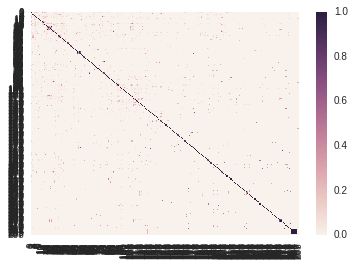

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cond_sim = cosine_similarity(diag.T)
sns.heatmap(cond_sim)

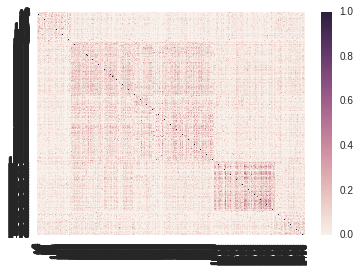

In [14]:
sns.heatmap(cosine_similarity(tfidf_all[:1500,:]))

In [15]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(tfidf_train, y_train)
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(tfidf_all, diag)



In [16]:
import pickle
with open("forum_vectorizer.pkl", 'wb') as handle:
    cloudpickle.dump(vectorizer, handle)
with open("condition_names.pkl", 'wb') as handle:
    cloudpickle.dump(cond_names, handle)
with open("forum_tfidf.pkl", 'wb') as handle:
    cloudpickle.dump(tfidf_all, handle)
with open("forum_db.pkl", 'wb') as handle:
    cloudpickle.dump(df[['post','response','label']], handle)
with open("forum_classifier.pkl", 'wb') as handle:
    cloudpickle.dump(clf, handle)
with open("condition_similarity.pkl", 'wb') as handle:
    cloudpickle.dump(cond_sim, handle)

In [ ]:
#load the content
# vectorizer = pickle.load(open("forum_vectorizer.pkl", "rb" ) )
# clf=pickle.load(open("forum_classifier.pkl", "rb" ) )
# tfidf_test = vectorizer.transform(X_test)
# predicted = clf.predict_proba(tfidf_test)

In [ ]:
# for test, pred in zip(y_test, np.array([a[:,1] for a in predicted]).T):
#     dl = np.array(cols)[test>0].tolist()
#     cl = np.array(cols)[pred>0.3].tolist()
#     print('%r => %s' % (dl, cl))
# for i in range(sim.shape[0]):
#     for j in range(i+1,sim.shape[0]):
#         if(sim[i,j]>0.4):
#             pass
#             print('%s,%s,%s' % (cols[i].split('_')[1], cols[j].split('_')[1], sim[i,j]))

In [ ]:
conditions=['acne','cancer']
tot = 10
percond = count/len(conditions)
subcond=list(conditions)
connect = 1
for c in conditions:
    sim = cond_sim[[i for i,x in enumerate(cond_names) if x == c],:][0]
    s = sorted(zip(sim,cond_names), key=lambda x: x[0], reverse=True)
    if(s[percond][0]<connect):
        connect=s[percond][0]
    subcond.extend([b for (a,b) in s[:percond]])

In [ ]:
subcond=list(set(subcond))
inds=[i for i,x in enumerate(cond_names) if x in subcond]
subsim=cond_sim[:,inds][inds,:]

In [ ]:
for i in range(subsim.shape[0]):
    for j in range(i+1,subsim.shape[0]):
        if(subsim[i,j]>=connect):
            print ('%s,%s,%s' % (subcond[i], subcond[j], subsim[i,j]))

In [ ]:
subcond